# **Motive behind Version:** 

This version of the code runs a similar neural network as the origninal code. However the data used only consists of 9 classes (typed phrases/passwords). Additionally this dataset only contains high quality thermal images to emulate a more controlled setup. This is done to validate the efficiency of the neural network itself and conclude that the poorer accuracy rates in the original version is a result of the data and the not the quality of the Neural Network

# **Part 1 - Importing Necessary libraries**  

Here we import all the necessary libraries

In [15]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
from pandas import read_csv
from __future__ import print_function
import pandas as pd
import shutil
import os
import sys
from os.path import join


# **Part 2 - Importing the necessary image data and CSV files**  

This section has the following functions - 


*   First we get the labels of the data from the csv file.
*   The obtained labels are then separated into Training and testing sets (8:2)

*   A small check is done to see whether the training and testing sets have the same number of unique classes.
*   The images are now separated into two different folders based on training and testing lists. 


In [16]:
map_file = read_csv('/content/drive/MyDrive/Colab Notebooks/Thermal Image/Version 4 - Small Dataset/Train.csv')
length = len(map_file)
print(length)
labels = set()
for i in range(len(map_file)):
    # convert spaced separated tags into an array of tags
    type = map_file['Password'][i].split('\n')
    # add tags to the set of known labels
    labels.update(type)
#print(labels)
labels = list(labels)
labels.sort()
classes = labels
classes

126


['1?wb:J5c6X[-5az7',
 '3}fW8&tR4bmdY_b7',
 'End by win a pun!',
 'Rh(3q4aRmWx!R)e',
 'The big dwarf only jumps?',
 'The world is a stage!',
 'gareth_king@post.cd',
 'gwen_king@post.com',
 'kyle_king@post.uk']

In [22]:
train_dir =r'/content/drive/MyDrive/Colab Notebooks/Thermal Image/Version 4 - Small Dataset/Image Data'
test_dir =r'/content/drive/MyDrive/Colab Notebooks/Thermal Image/Version 4 - Small Dataset/Image Data'
#Please make sure to change the path in the above line during testing when testing
train_path = r"train_label"
test_path =  r"test_label"
if not os.path.exists(train_path):
    os.mkdir(train_path)

if not os.path.exists(test_path):
    os.mkdir(test_path)

#### **Disclaimer during testing : Please check the path of the training and testing directory, and the CSV files. As mentioned in the user guide, please copy the path from your drive for the directory containing the images and the CSV files.**

##**Subpart 1**

The images are divided into training and testing directories depending on the training and testing labels. 

In [23]:
for i in range(2):
  ran = np.random.RandomState()
  training_labels = map_file.sample(frac=0.8, random_state=ran)
  testing_labels = map_file.loc[~map_file.index.isin(training_labels.index)]
  training_label_class = []
  testing_label_class = []
  for File_Name, Class_Name in training_labels.values:
    if Class_Name not in training_label_class:
        training_label_class.append(Class_Name)
        

  for File_Name, Class_Name in testing_labels.values:
    if Class_Name not in testing_label_class:
        testing_label_class.append(Class_Name)

  for File_Name, Class_Name in training_labels.values:
    # Create subdirectory with `Class_Name`
    if not os.path.exists(train_path + '/'+ str(Class_Name)):
        os.mkdir(train_path + '/'+ str(Class_Name))
    src_path = train_dir + '/'+ str(File_Name) + '.jpg'
    dst_path = train_path + '/'+ str(Class_Name) + '/' + str(File_Name) + '.jpg'
    try:
        shutil.copy(src_path, dst_path)
        print("File Transfer Successful")
    except:
        print('Error')
        
  for File_Name, Class_Name in testing_labels.values:
    # Create subdirectory with `Class_Name`
    if not os.path.exists(test_path + '/'+ str(Class_Name)):
        os.mkdir(test_path + '/'+ str(Class_Name))
    src_path = test_dir + '/'+ str(File_Name) + '.jpg'
    dst_path = test_path + '/'+ str(Class_Name) + '/' + str(File_Name) + '.jpg'
    try:
        shutil.copy(src_path, dst_path)
        print("File Transfer Successful")
    except:
        print('Error')



        

File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful
File Transfer Successful


# **Part 3 - Designing the Neural Network**  

Now we start designing the Neural Network. We chose to use Convolutional Neural Network which was designed using the PyTorch Library. 


#### **Subpart 1**


*   
We define a transfomer and that resizes the image and transforms the file to tensor
*   We also check if the device is running on cuda or CPU



In [24]:
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("device type : ",device)
transformer=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), 
])

device type :  cpu


#### **Subpart 2**


We now load the data



In [25]:
Dataloader_training=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=8, shuffle=True
)
Dataloader_testing=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=4, shuffle=True
)

#### **Subpart 3 - The CNN Network**

Unlike the network with the original dataset, this one only classifies 9 labels. 




In [26]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=9):
        super(ConvNet,self).__init__()
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=10,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=10)
        self.relu1=nn.ReLU()  
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        
        self.conv2=nn.Conv2d(in_channels=10,out_channels=24,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
    
        self.conv3=nn.Conv2d(in_channels=24,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=32 **3,out_features=num_classes)
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
             
        output=output.view(-1,32**3)
                
        output=self.fc(output)
            
        return output

In [27]:
model=ConvNet(num_classes=9).to(device)

In [28]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
epoch_count = 50



In [30]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

# **Part 4 - Training and Testing the Network**  

The network is trained and tested 50 times and the best result in terms of accuracy is retained.


In [31]:
best_accuracy=0.0
predlist_final=[]
lbllist_final=[]

for epoch in range(epoch_count):
    predlist=[]
    lbllist=[]
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(Dataloader_training):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(Dataloader_testing):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        predlist.extend(prediction)
        lbllist.extend(labels.data)
    test_accuracy=test_accuracy/test_count
    
    
    print('Iteration: '+str(epoch)+'\nTrain Loss: '+str(train_loss)+'\nTrain Accuracy: '+str(train_accuracy)+'\nTest Accuracy: '+str(test_accuracy))
    print("\n\n")
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
        predlist_final.clear()
        lbllist_final.clear()
        predlist_final = predlist[:]
        lbllist_final = lbllist


Iteration: 0
Train Loss: tensor(2.9589)
Train Accuracy: 0.08943089430894309
Test Accuracy: 0.19148936170212766



Iteration: 1
Train Loss: tensor(2.3936)
Train Accuracy: 0.2032520325203252
Test Accuracy: 0.1276595744680851



Iteration: 2
Train Loss: tensor(2.0895)
Train Accuracy: 0.2845528455284553
Test Accuracy: 0.1276595744680851



Iteration: 3
Train Loss: tensor(1.7864)
Train Accuracy: 0.43089430894308944
Test Accuracy: 0.2978723404255319



Iteration: 4
Train Loss: tensor(1.6785)
Train Accuracy: 0.4715447154471545
Test Accuracy: 0.7021276595744681



Iteration: 5
Train Loss: tensor(1.3284)
Train Accuracy: 0.6422764227642277
Test Accuracy: 0.5531914893617021



Iteration: 6
Train Loss: tensor(1.2943)
Train Accuracy: 0.6178861788617886
Test Accuracy: 0.6808510638297872



Iteration: 7
Train Loss: tensor(1.0907)
Train Accuracy: 0.7317073170731707
Test Accuracy: 0.6170212765957447



Iteration: 8
Train Loss: tensor(0.9347)
Train Accuracy: 0.7804878048780488
Test Accuracy: 0.765957446

# **Part 5 - Results and Visualization**

This part is divided into the following part - 


*   Display accuracy

*   Show confusion matrix
*   Calculate Precision and Recall


*   Display all results




In [32]:
print("The highest accuracy among all iteration is " + str(best_accuracy*100) + " %")



The highest accuracy among all iteration is 93.61702127659575 %


[[7 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0]
 [0 0 1 0 6 0 0 0 0]
 [0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 4 0 0]
 [1 0 0 0 0 0 0 4 0]
 [1 0 0 0 0 0 0 0 5]]


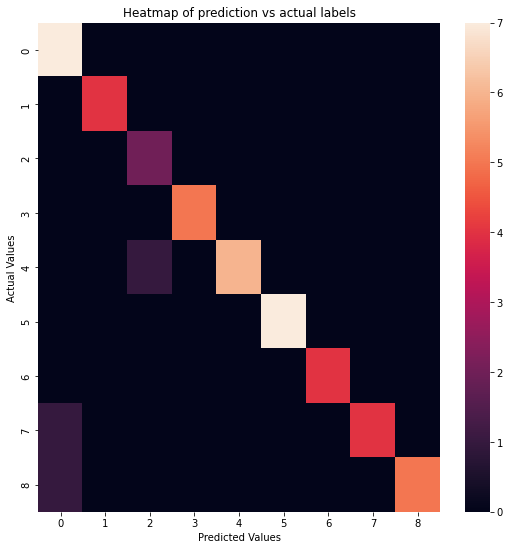

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
conmat = confusion_matrix(lbllist_final, predlist_final)
#disp = ConfusionMatrixDisplay(confusion_matrix=conmat)
#disp.plot()
#plt.show()
print(conmat)
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(conmat)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
ax.set_title('Heatmap of prediction vs actual labels')
plt.show()






In [34]:
FP = conmat.sum(axis=0) - np.diag(conmat)  
FN = conmat.sum(axis=1) - np.diag(conmat)
TP = np.diag(conmat)
TN = conmat.sum() - (FP + FN + TP)

In [35]:
print(FP)
print(FN)
print(TP)
print(TN)

[2 0 1 0 0 0 0 0 0]
[0 0 0 0 1 0 0 1 1]
[7 4 2 5 6 7 4 4 5]
[38 43 44 42 40 40 43 42 41]


In [36]:
def Precision (TP, FP):
  ans = 0
  total = 0
  for i in range(len(TP)):
    total +=1
    ans += (TP[i])/(TP[i]+FP[i])
  return ans/total 

In [37]:
def Recall (TP, FN):
  ans = 0
  total = 0
  for i in range(len(TP)):
    total +=1
    ans += (TP[i])/(TP[i]+FN[i])
  return ans/total 

In [38]:
print("Accuracy of the best model : ", str(best_accuracy*100) + " %")
print("Average Precision of best model :", str(Precision(TP,FP)*100) + "%")
print("Average Recall of best model :", str(Recall(TP,FN)*100), "%")

Accuracy of the best model :  93.61702127659575 %
Average Precision of best model : 93.82716049382717%
Average Recall of best model : 94.33862433862434 %


**Disclaimer - Due to the Training and Testing Set Split being randomized, the accuracy will differ slightly during different uses of this model.**

# **Citations**  

This code was created with the help of several online tutorials and books which are listed below - 


*   Sewak, Mohit, Md Rezaul Karim, and Pradeep Pujari. Practical convolutional neural networks: implement advanced deep learning models using Python. Packt Publishing Ltd, 2018.

*   [https://www.youtube.com/watch?v=9OHlgDjaE2I](https://www.youtube.com/watch?v=9OHlgDjaE2I,)

*   [https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html](https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html,)
*   [https://www.youtube.com/watch?v=7q7E91pHoW4&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=11&ab_channel=PythonEngineer](https://www.youtube.com/watch?v=7q7E91pHoW4&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=11&ab_channel=PythonEngineer,)


*   [https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14&ab_channel=PythonEngineer](https://www.youtube.com/watch?v=pDdP0TFzsoQ&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=14&ab_channel=PythonEngineer,)






